# Notebook for Tuning models
Here we selected 4 models - Logistic Regression, Support Vector Classifier, Random Forest and K-Nearest Neighbours - and tuned their hyperparameters using bootstrap sampling
# Table of contents
1. Load dataset
2. Run GridSearch
3. Plot results
4. Create table of ML experiments


In [1]:
import os
import configparser

import numpy as np
import pandas as pd

from source.processes import Shuffler
from source.datamodels.datamodels import GridSearchResults
from source.datamodels.datamodels import Axes, Stats
from source.utils import get_project_root

In [2]:
root = get_project_root()
config = configparser.ConfigParser()
config.read(os.path.join(root, "userconfig.ini"))

own_data_path = config['Path']['own_data_path']
third_party_data_path = config['Path']['third_party_data_path']
Cesar1_path = config['Path']['Cesar1_path']

images_path = config['Path']['images_path']
public_images_path = config['Path']['public_images_path']

tables_path = config['Path']['tables_path']
public_tables_path = config['Path']['public_tables_path']

bootstrap_jsons_path = config['Path']['bootstrap_jsons_path']
single_jsons_path = config['Path']['single_jsons_path']

# 1 Load dataset

In [4]:
prepared_data = pd.read_csv(os.path.join(root, own_data_path, 'DSM_processed_signal_specter500_noscale.csv'), delimiter=',')  # our experiment
prepared_data.head()

,target,group,a1_x_signal_higuchi_fd,a1_x_signal_activity,a1_x_signal_std,a1_x_signal_crest_factor,a1_x_signal_energy,a1_x_signal_hurst,a1_x_signal_shannon_entropy,a1_x_signal_range,...,a2_z_specter_petrosian_fd,a2_z_specter_katz_fd,a2_z_specter_mean,a2_z_specter_complexity,a2_z_specter_sample_entropy,a2_z_specter_detrended_fluctuation,a2_z_specter_permutation_entropy,a2_z_specter_kurtosis,a2_z_specter_approx_entropy,a2_z_specter_iqr
0,0.0,1.0,1.584780,0.519530,2.078757,3.583394,11784.249294,0.626170,6.388020,13.371285,...,1.037972,2.316920,15.117545,1.501372,0.792652,0.802960,2.577444,26.197734,0.505887,7.601536
1,0.0,1.0,1.571519,0.519920,2.260749,3.050062,13991.570232,0.633813,6.507361,13.659874,...,1.038975,2.273315,13.299981,1.409292,0.760192,0.718525,2.582064,43.518149,0.476081,7.584814
2,0.0,1.0,1.635675,0.531458,2.237654,3.156487,13666.278173,0.625745,6.489806,13.178892,...,1.036964,2.089324,13.819344,1.420251,0.669468,0.753449,2.570758,60.607563,0.428120,7.918581
3,0.0,1.0,1.607396,0.512090,2.098390,3.090305,12034.432981,0.606942,6.422261,12.216929,...,1.038474,1.684095,15.137277,1.319687,0.491291,0.666028,2.574908,119.135147,0.309202,7.217267
4,0.0,1.0,1.601883,0.526677,2.155084,3.760177,12714.120421,0.631058,6.449559,15.391407,...,1.039851,1.887228,14.054032,1.348106,0.584473,0.647026,2.577000,71.266039,0.373227,6.850947


# 2 Run GridSearch

In [5]:
# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [6]:
LR_estimator = LogisticRegression(max_iter=100000)
SVC_estimator = SVC()
RFC_estimator = RandomForestClassifier()
GBM_estimator = GradientBoostingClassifier()
KNN_estimator = KNeighborsClassifier()

In [7]:
LR_grid = {"C": list(np.logspace(-3, 6, 10))}  # np.ndarrays are not serializable
SVC_grid = {"C": list(np.logspace(-3, 6, 10)), 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
RFC_grid = {'n_estimators': [50, 100, 200, 300], 'max_depth': [3, 5, 9, 15, 30]}
KNN_grid = {'n_neighbors': [1, 3, 5, 7, 9, 15, 35], 'p': [1, 1.5, 2, 2.5, 6, 100]}

In [8]:
X = prepared_data.drop(columns=['target', 'group']).values
y = prepared_data['target'].values
groups = prepared_data['group'].values

X_scaled = StandardScaler().fit_transform(X)

In [ ]:
from datetime import datetime
from source.datamodels.iterators import Metrics

GS_results_objects = []

estimators = [LR_estimator, SVC_estimator, RFC_estimator, KNN_estimator]
grids = [LR_grid, SVC_grid, RFC_grid, KNN_grid]
names = ['LR', 'SVC', 'RFC', 'KNN']

n_repeats = 100
score_names = Metrics.get_scorers_dict()

for estimator, grid, name in zip(estimators, grids, names):
    json_grid = dict()
    for key, val in zip (grid.keys(), grid.values()):
        if isinstance(val, np.ndarray):
            json_grid[key] = list(val)
        else:
            json_grid[key] = val
    start_time = datetime.now()
    cv = Shuffler.OverlapGroupCV(train_size=0.63, n_repeats=n_repeats).split(X_scaled, y, groups)
    GSCV = GridSearchCV(estimator, grid, scoring=score_names, cv=cv, refit="f1")
    GSCV.fit(X_scaled, y, groups=groups)

    print(f"Best score for {name}: {100*GSCV.best_score_:.3f}% \n best params: {GSCV.best_params_}\n required time: {datetime.now() - start_time}")

    highest_score_params = GSCV.best_index_
    bootstrap_scores_distr = dict()
    scores = dict()
    for score_name in score_names.keys():

        split_scores_names = [f'split{idx}_test_{score_name}' for idx in range(n_repeats)]

        scores_distr = []
        for split_scores_name in split_scores_names:
            scores_distr.append(float(GSCV.cv_results_[split_scores_name][highest_score_params]))
        bootstrap_scores_distr[score_name] = scores_distr.copy()
        scores[score_name] = np.mean(scores_distr)

    res = GridSearchResults(
        run_label = "GS",
        model_name = name,
        hyperparameters = GSCV.best_params_,
        hyperparameters_grid = json_grid,
        use_signal = True,
        use_specter = True,
        specter_threshold = 500,
        axes = Axes.get_keys(),
        stats = Stats.get_keys(),
        predictions = None,
        scores = scores,
        resampling_number = n_repeats,
        bootstrap_scores =  bootstrap_scores_distr
    )
    GS_results_objects.append(res)

In [10]:
from source.postprocessing.mljson import serialize_results


serialize_results(GS_results_objects, filenames=[f"{model}_GS_AXYZ_signal_spectrum500.json" for model in names], filepath=os.path.join(root, bootstrap_jsons_path, 'GridSearch'))

# 3 Plot the results

In [5]:
from source.postprocessing.mljson import deserialize_results
from source.datamodels.iterators import Metrics


names = ['LR', 'SVC', 'RFC', 'KNN']
score_names = Metrics.get_scorers_dict()

GS_results_objects = deserialize_results(GridSearchResults, filenames=[f"{model}_GS_AXYZ_signal_spectrum500.json" for model in names], filepath=os.path.join(root, bootstrap_jsons_path, 'GridSearch'))

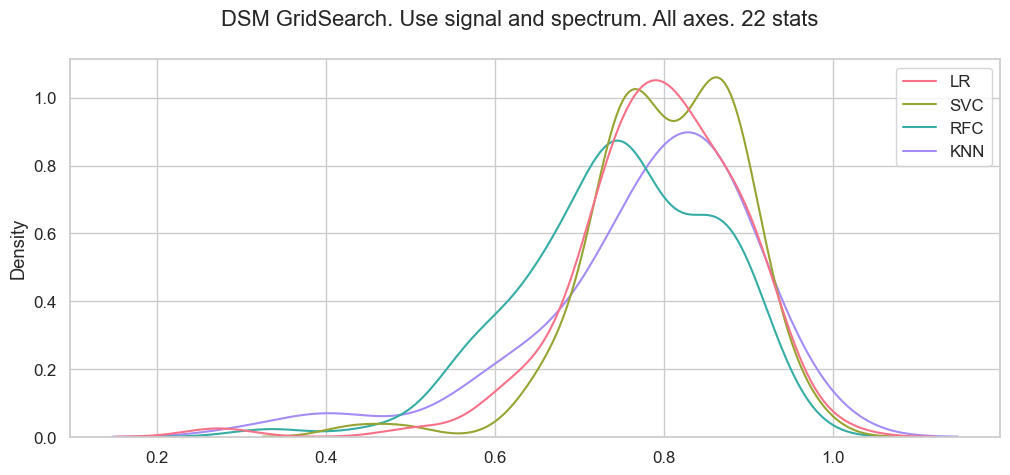

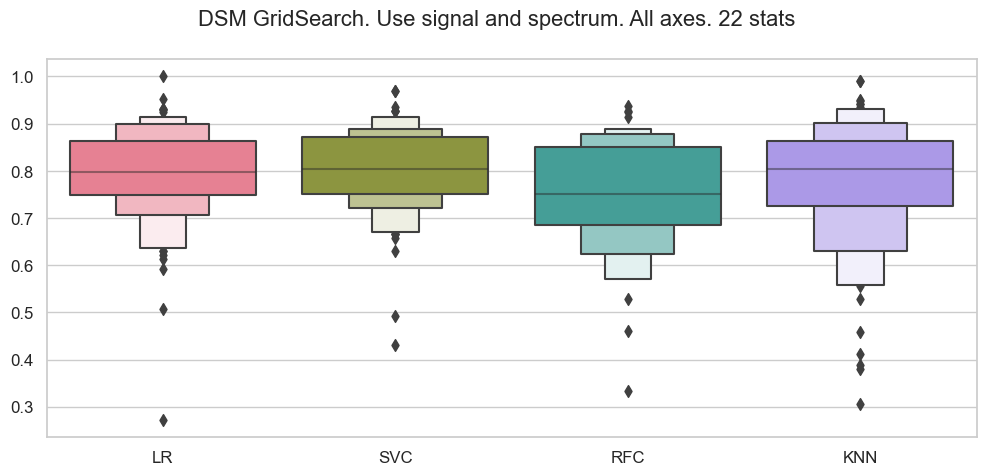

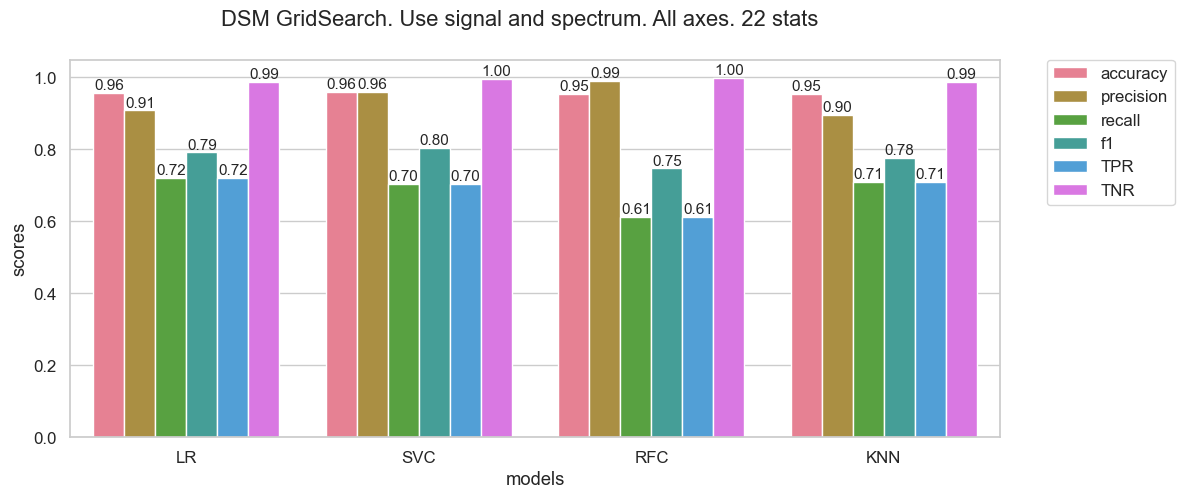

In [7]:
from source.postprocessing.plotter import dist_plot, bar_plot


plot_info = '. Use signal and spectrum. All axes. 22 stats'
filename_info = 'GS_AXYZ_22stats_6_11_2021'
dist_plot(results=GS_results_objects, models=names, plot_type='kdeplot', metric='f1', title=f'DSM GridSearch{plot_info}', to_png=True, filename=f'kde_DSM_{filename_info}.png', filepath=os.path.join(root, images_path, 'DSM_GS'))

dist_plot(results=GS_results_objects, models=names, plot_type='boxenplot', metric='f1', title=f'DSM GridSearch{plot_info}', to_png=True, filename=f'box_DSM_{filename_info}.png', filepath=os.path.join(root, images_path, 'DSM_GS'))

bar_plot(results=GS_results_objects, models=names, metrics=score_names.keys(), title=f'DSM GridSearch{plot_info}', plot_vals=True, to_png=True, filename=f'bar_DSM_{filename_info}.png', filepath=os.path.join(root, images_path, 'DSM_GS'))

# 4 Create table with results
Since we were building models for two datasets (our dataset, also called as DSM, and Cesar Ricardo №2 dataset), we created two tables with the results of the experiments.

In [7]:
from source.postprocessing.mlcsv import generate_csv_from_results, create_readable_xlsx
from source.postprocessing.mljson import deserialize_results

In [8]:
whole_results = deserialize_results(GridSearchResults, filepath=os.path.join(root, bootstrap_jsons_path, 'GridSearch'))
generate_csv_from_results(whole_results, "DSM_GS.csv", results_type=GridSearchResults, csv_path=os.path.join(root, tables_path))
create_readable_xlsx("DSM GridSearch results.xlsx", "DSM_GS.csv", csv_path=os.path.join(root, tables_path), xlsx_path=os.path.join(root, tables_path, 'public'))

In [10]:
whole_results = deserialize_results(GridSearchResults, filepath=os.path.join(root, bootstrap_jsons_path, 'GridSearch', 'C2'))
generate_csv_from_results(whole_results, "C2_GS.csv", results_type=GridSearchResults, csv_path=os.path.join(root, tables_path))
create_readable_xlsx("Cesar 2 GridSearch results.xlsx", "DSM_GS.csv", csv_path=os.path.join(root, tables_path), xlsx_path=os.path.join(root, tables_path, 'public'))